<a href="https://colab.research.google.com/github/boseull/tensorflow_example/blob/main/tensorflow_%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%97%B0%EB%B9%84_%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.5.0


## 데이터셋 구하기

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
#mpg : 연비

32768/30286 [================================] - 0s 2us/step


In [3]:
dataset_path


'/root/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

raw_dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset = raw_dataset.copy() #왜 굳이 copy?
dataset.tail() #데이터 표의 하단 부분 출력

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


##데이터 정제하기

In [6]:
dataset.isna().sum() #데이터가 비어있으면 1, 데이터가 있으면 0

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna() #비어있는 행 전체 삭제
origin = dataset.pop('Origin') #origin 열만 빼냄

dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


##훈련 셋과 테스트 셋으로 분할

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## 데이터 조사

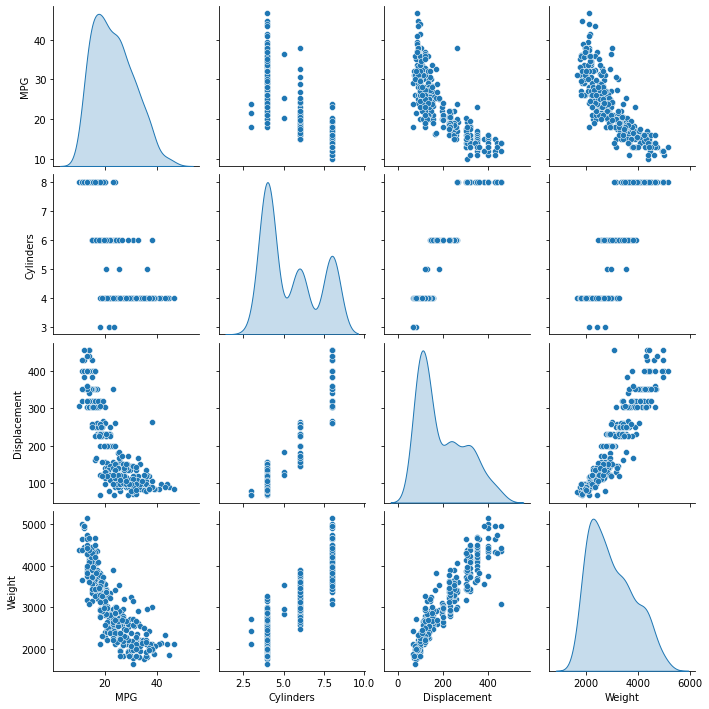

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


##특성과 레이블 분리

In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## 데이터 정규화

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

##모델 만들기

In [13]:
def build_model():
  model = keras.Sequential([layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]), layers.Dense(64, activation='relu'), layers.Dense(1)])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

  return model

model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [14]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result


array([[-0.24635223],
       [-0.10902604],
       [-0.43578973],
       [-0.10145003],
       [-0.04345907],
       [-0.05067009],
       [-0.04106872],
       [-0.40984035],
       [-0.22959962],
       [-0.10377206]], dtype=float32)

##모델 훈련

In [17]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,6.093789,1.730657,6.093789,8.468485,2.263218,8.468485,95
96,6.036708,1.723755,6.036708,8.766626,2.194044,8.766626,96
97,6.202505,1.761974,6.202505,8.591480,2.193715,8.591480,97
98,6.042460,1.705373,6.042460,8.592083,2.286870,8.592083,98
99,6.099157,1.679634,6.099157,8.486133,2.222606,8.486133,99


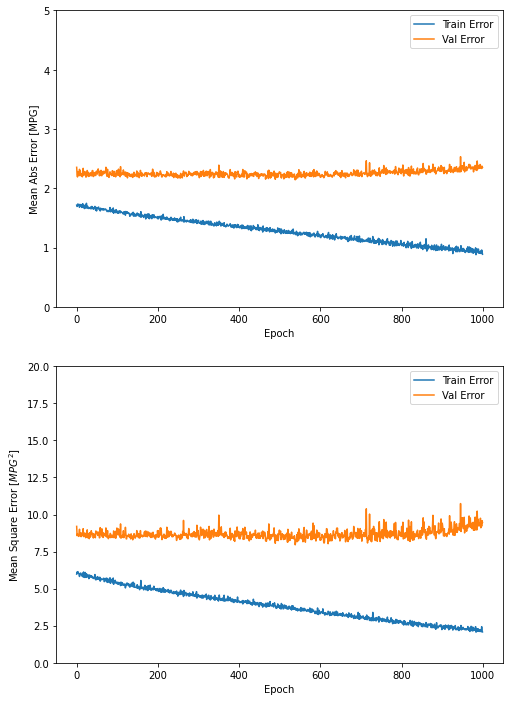

In [18]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot()
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

##점수가 향상되지 않으면 자동으로 훈련 멈춤


......................................................

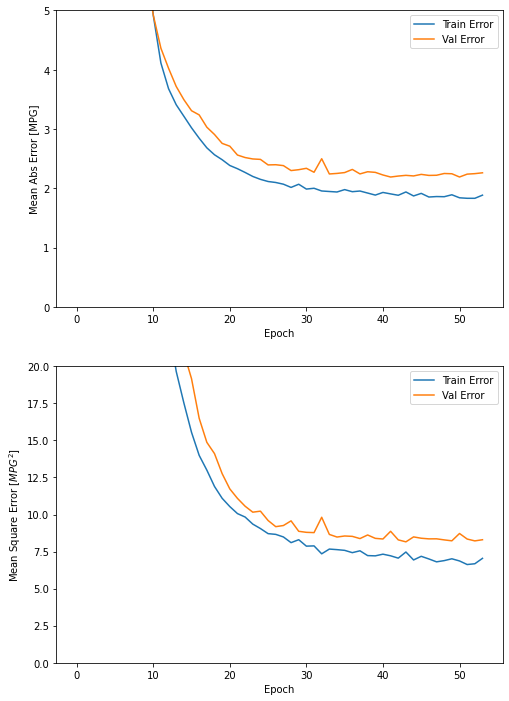

In [20]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

테스트 세트로 모델 성능 확인

In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2) #loss = mse 예측과 실제의 차이의 제곱의 합의 반, mae 예측과 실제의 차이의 절대값의 반 

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))


3/3 - 0s - loss: 5.6691 - mae: 1.8028 - mse: 5.6691
테스트 세트의 평균 절대 오차:  1.80 MPG


##예측

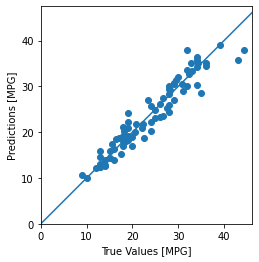

In [22]:
test_predictions = model.predict(normed_test_data).flatten() #1차원 배열로 만들기

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_=plt.plot([-100, 100], [-100, 100])

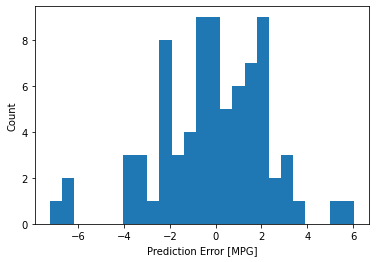

In [23]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_=plt.ylabel("Count")